In [1]:
import os
import re
import pandas as pd

In [2]:
cwd = os.getcwd()
exp_dir = os.path.join(cwd,'REB_for_figshare/PST_104E_expression')

In [3]:
actin = ['jgi_Pucstr1_9243_evm.model.scaffold_189.36', 'jgi_Pucstr1_604_evm.model.scaffold_10.29']
tuba = ['jgi_Pucstr1_21215_evm.model.scaffold_48.150', 'jgi_Pucstr1_18794_evm.model.scaffold_4.135']
tubb = ['jgi_Pucstr1_26984_evm.model.scaffold_77.18', 'jgi_Pucstr1_20937_evm.model.scaffold_47.84', 'jgi_Pucstr1_5087_evm.model.scaffold_139.77', 'jgi_Pucstr1_15260_evm.model.scaffold_3.88']
efact = ['jgi_Pucstr1_27007_evm.model.scaffold_77.53', 'jgi_Pucstr1_20962_evm.model.scaffold_47.122']
pst130_p495001 = ['jgi_Pucstr1_474_evm.model.scaffold_1.556']

housekeeping = actin + tuba + tubb + efact

In [4]:

housekeeping_genes_dict = {
    'actin': actin,
    'tuba': tuba,
    'tubb': tubb,
    'efact': efact,
    'pst130_p495001': pst130_p495001
}

table_data = {}

for file in os.listdir(exp_dir):
    if file.endswith('count_0.tsv') and 'Dobon' not in file:
        df = pd.read_csv(os.path.join(exp_dir, file), sep='\t', index_col=0, header=0)
        for sample in df.columns:
            gene_avgs = {}
            for gene_name, gene_ids in housekeeping_genes_dict.items():
                valid_ids = [gid for gid in gene_ids if gid in df.index]
                avg_expression = df.loc[valid_ids, sample].mean() if valid_ids else float('nan')
                gene_avgs[gene_name] = avg_expression
            table_data[(file, sample)] = gene_avgs

rows = []
for (f, s), gene_data in table_data.items():
    row = {'File': f, 'Sample': s}
    row.update(gene_data)
    rows.append(row)

result_df = pd.DataFrame(rows)
result_df.to_csv('housekeeping_average_expression.csv', index=False)


In [8]:
exp_dict = {}
pst130_p495001_dict = {}
house_dict = {}

pst130_p495001_pattern = re.compile(r'jgi_Pucstr1_474_evm\.model\.scaffold_1.*')

for file in os.listdir(exp_dir):
    if file.endswith('count_0.tsv') and 'Dobon' not in file:
        # print(file)
        df = pd.read_csv(os.path.join(exp_dir, file), sep='\t', index_col=0, header=0)
        
        for sample in df.columns:
            sample_exp = df.loc[housekeeping, sample].mean()
            pst130_p495001_exp = df.loc[pst130_p495001, sample].mean()
            pst130_p495001_exp = df.loc[df.index.str.contains(pst130_p495001_pattern), sample].mean()
            if '.1' in sample:
                sample = sample.replace('.1', '')
            if sample not in exp_dict:
                exp_dict[sample] = []
            if sample not in pst130_p495001_dict:
                pst130_p495001_dict[sample] = []
            if sample not in house_dict:
                house_dict[sample] = []
            exp_dict[sample].append(sample_exp)
            pst130_p495001_dict[sample].append(pst130_p495001_exp)
            

In [9]:
median_exp = pd.Series([exp for sample in exp_dict for exp in exp_dict[sample]]).median()
print(0.2*median_exp)

394.62


In [10]:
low_exp_samples = [sample for sample,exp in exp_dict.items() if pd.Series(exp).mean() < 0.15 * median_exp]
print(abs((len(low_exp_samples)-len(exp_dict))/len(exp_dict)*100))
print(len(low_exp_samples))
print(len(exp_dict)-len(low_exp_samples))

89.51612903225806
104
888


In [11]:
for sample,exp in pst130_p495001_dict.items():
    if exp[0] == 0 and sample not in low_exp_samples:
        print(sample, exp)

17_0120 [0.0]
16_0265 [0.0]
17_0588 [0.0]
16_0401 [0.0]
17_0277 [0.0]
15_0517 [0.0]
15_0523 [0.0]
15_0616 [0.0]
16_0337 [0.0]
16_0338 [0.0]
12_08NZ [0.0]


In [12]:
with open(os.path.join(cwd,'low_exp_samples.txt'), 'w') as f, open(os.path.join(cwd,'high_exp_samples.txt'), 'w') as f2:
    for sample in low_exp_samples:
        f.write(sample + '\n')
    for sample in exp_dict:
        if sample not in low_exp_samples:
            f2.write(sample + '\n')


17_0120 [0.0]
16_0265 [0.0]
17_0588 [0.0]
16_0401 [0.0]
17_0277 [0.0]
15_0517 [0.0]
15_0523 [0.0]
15_0616 [0.0]
16_0337 [0.0]
16_0338 [0.0]
12_08NZ [0.0]


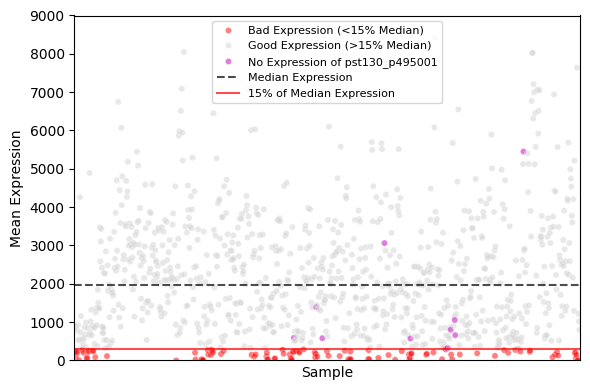

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

expression = pd.DataFrame([exp_dict[sample] for sample in exp_dict], index=exp_dict.keys()).T
expression_melted = expression.melt(var_name="Sample", value_name="Expression")
expression_melted['low_exp'] = expression_melted['Sample'].isin(low_exp_samples)

expression_melted['noexp_pst130_p495001'] = False
for sample, exp in pst130_p495001_dict.items():
    if exp[0] == 0 and sample not in low_exp_samples:
        expression_melted.loc[expression_melted['Sample'] == sample, 'noexp_pst130_p495001'] = True
        print(sample, exp)

expression_melted['Category'] = 'Good Expression (>15% Median)'
expression_melted.loc[expression_melted['low_exp'], 'Category'] = 'Bad Expression (<15% Median)'
expression_melted.loc[expression_melted['noexp_pst130_p495001'], 'Category'] = 'No Expression of pst130_p495001'

fig, ax = plt.subplots(figsize=(6, 4))

sns.scatterplot(
    data=expression_melted,
    x="Sample",
    y="Expression",
    hue="Category",
    palette={"Good Expression (>15% Median)": "lightgrey", "Bad Expression (<15% Median)": "r", "No Expression of pst130_p495001": "m"},
    ax=ax,
    s=20,
    alpha=0.5
)

ax.axhline(median_exp, color='black', linestyle='--', label='Median Expression', alpha=0.7)
ax.axhline(median_exp*0.15, color='red', linestyle='-', label='15% of Median Expression', alpha=0.7)

ax.set_xlabel("Sample")
ax.set_xticks([])
ax.set_ylabel("Mean Expression", fontsize=10)
ax.set_ylim(0, 9000)
ax.set_xlim(-1, len(exp_dict))
ax.legend(title="", fontsize=8)

plt.tight_layout()

new_rc_params = {'text.usetex': False,"svg.fonttype": 'none'}
mpl.rcParams.update(new_rc_params)
plt.savefig('scatter_expression.svg')


# Calculate average coverage for each sample

In [15]:
metadata_df = pd.read_csv('all_metadata_no_dobon.tsv', sep='\t', index_col=0, header=0)

for file in os.listdir(exp_dir):
    if file.endswith('count_0.tsv') and 'Dobon' not in file:
        df = pd.read_csv(os.path.join(exp_dir, file), sep='\t', index_col=0, header=0)

        mean_coverages = {}
        for sample in df.columns:
            mean_coverage = df[sample].mean()
            mean_coverages[sample] = mean_coverage
        
        for sample, mean_coverage in mean_coverages.items():
            if sample in metadata_df['run_accession'].values:
                metadata_df.loc[metadata_df['run_accession'] == sample, 'Mean_Coverage'] = mean_coverage
                if sample in low_exp_samples:
                    metadata_df.loc[metadata_df['run_accession'] == sample, 'Selected'] = 'No'
                else:
                    metadata_df.loc[metadata_df['run_accession'] == sample, 'Selected'] = 'Yes'
                

metadata_df.to_csv('updated_metadata.tsv', sep='\t')